## Юнит 5. Основные алгоритмы машинного обучения. Часть I 
### Skillfactory: DSPR-19
### Pre-project. Компьютер говорит "Нет"

In [4]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('./pre-project_data/train.csv')

### Задание 1
Сколько записей содержит набор данных для моделирования?

In [3]:
data.shape[0]

73799

**Посмотрим на данные:**
 
 |         |                     |
 |---------|---------------------|
 |client_id|идентификатор клиента|
 |education	|уровень образования|
 |sex	|пол заёмщика|
 |age	|возраст заёмщика|
 |car|	флаг наличия автомобиля|
 |car_type|	флаг автомобиля-иномарки|
 |decline_app_cnt|	количество отказанных прошлых заявок|
 |good_work|	флаг наличия «хорошей» работы|
 |bki_request_cnt|	количество запросов в БКИ|
 |home_address|	категоризатор домашнего адреса|
 |work_address|	категоризатор рабочего адреса|
 |income|	доход заёмщика|
 foreign_passport|	наличие загранпаспорта|
 |default|	наличие дефолта|

In [5]:
# удалим client_id идентификатор клиента
data.drop(columns='client_id',inplace=True)

### Задание 2
Постройте диаграмму для переменной `default`. Каких клиентов у банка больше?
- совершивших дефолт
- без дефолта

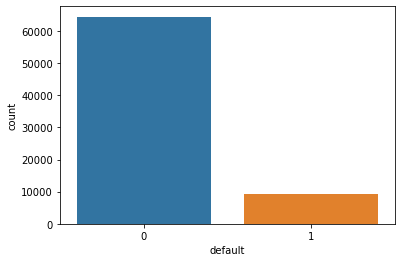

In [6]:
sns.countplot(x="default", data=data);

Посмотрим на тип данных и наличие пропусков:

In [7]:
data.info(verbose=False); print()

for col in data.columns: print('{:20} {}'.format(col, type(data.loc[0][col])))

data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Columns: 13 entries, education to default
dtypes: int64(8), object(5)
memory usage: 7.3+ MB

education            <class 'str'>
sex                  <class 'str'>
age                  <class 'numpy.int64'>
car                  <class 'str'>
car_type             <class 'str'>
decline_app_cnt      <class 'numpy.int64'>
good_work            <class 'numpy.int64'>
bki_request_cnt      <class 'numpy.int64'>
home_address         <class 'numpy.int64'>
work_address         <class 'numpy.int64'>
income               <class 'numpy.int64'>
foreign_passport     <class 'str'>
default              <class 'numpy.int64'>


education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.

Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

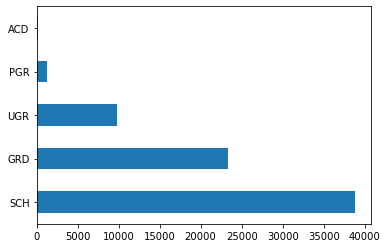

In [12]:
data.education.value_counts().plot.barh()

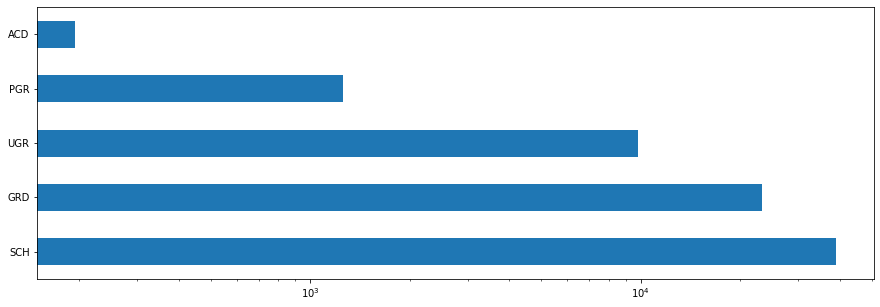

In [13]:
plt.figure(    figsize=(15,5))
data.education.value_counts().plot.barh()
plt.xscale("log")

### ЗАДАНИЕ

А теперь самостоятельно заполните пропуски в поле 'education' любыми известными вам методами.

In [14]:
# заполним пропуски 
data.education.fillna('NAN_EDU', inplace=True)

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [15]:
data.nunique().sort_values(ascending=False)

income              966
age                  52
bki_request_cnt      38
decline_app_cnt      21
education             6
work_address          3
home_address          3
default               2
foreign_passport      2
good_work             2
car_type              2
car                   2
sex                   2
dtype: int64

In [16]:
num_uniq = data.drop(columns='default').nunique()

bin_cols = data.drop(columns='default').columns[num_uniq==2]
cat_cols = data.drop(columns='default').columns[(num_uniq>2) & (num_uniq<7)] 
num_cols = data.drop(columns='default').columns[num_uniq>6]

Посмотрим на распределение числовых данных:

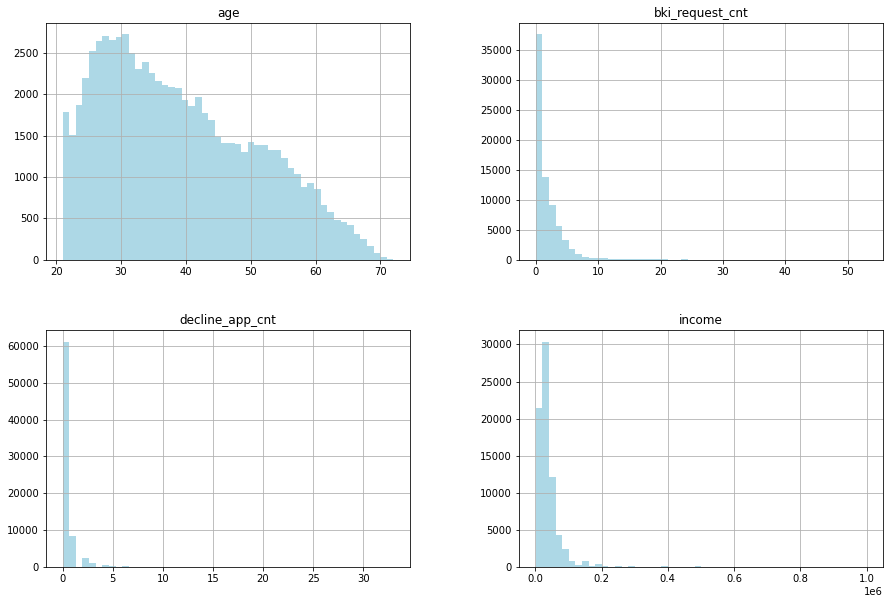

In [18]:
data[num_cols].hist(figsize=(15,10),bins = 50, color='lightblue');

_Насколько я помню, для того чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда я смогу избежать чувствительности к сильным отклонениям в суммах у линейных моделей._

Построим графики распределения логарифмированных переменных.



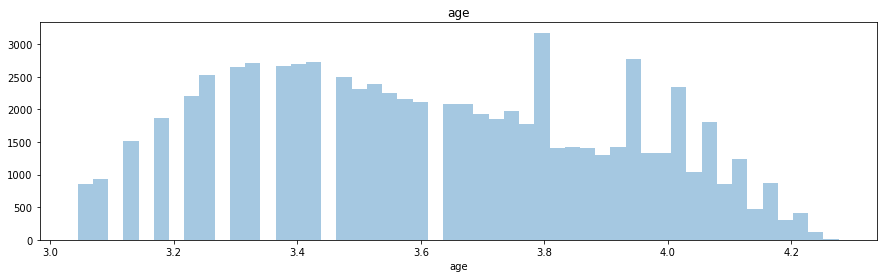

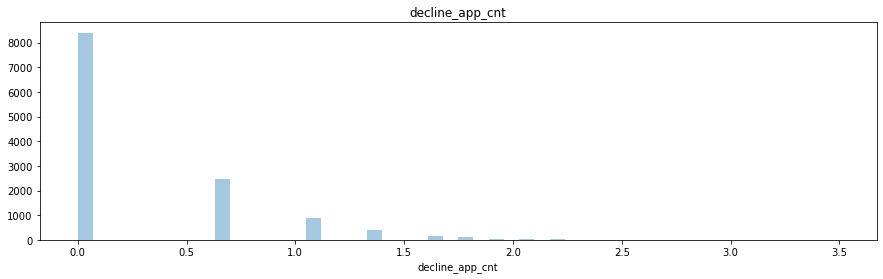

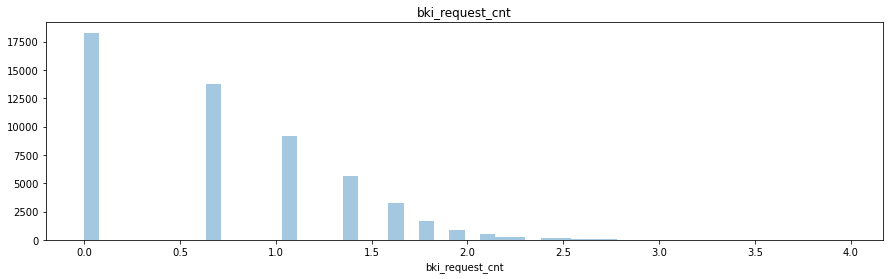

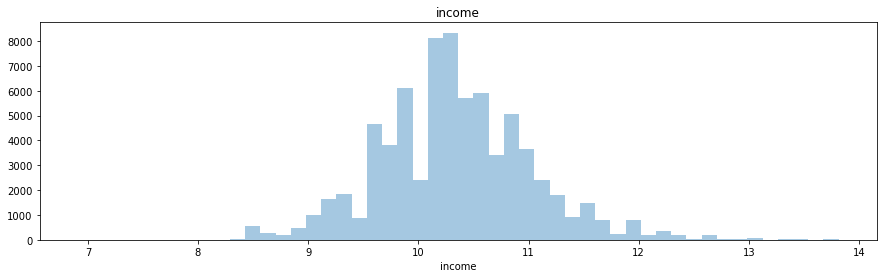

In [19]:
for i in num_cols:
    plt.figure(figsize=(15,4))
    sns.distplot(np.log(data[i][data[i] > 0].dropna()), kde = False, rug=False)
    plt.title(i)
    plt.show()

Некоторые переменные стали менее смещёнными. Такой принцип можно применить перед построением модели и сравнить значение метрики.

### Задание 1
Постройте boxplot’ы для численных переменных и ответьте на следующие вопросы:

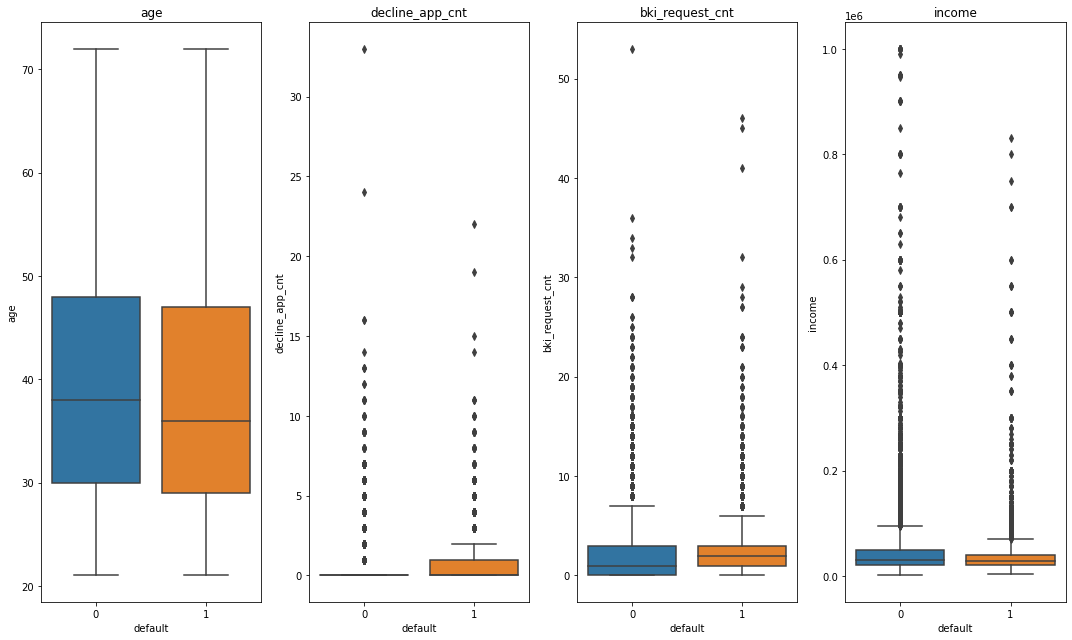

In [20]:
plt.figure(figsize=(15,9))

for i, column in enumerate(num_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x='default',y=data[column],data=data)
    plt.title(column)

plt.tight_layout()

**Оценка корреляций**

Сильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок. Что можно сделать:
- Отобрать низко коррелируемые признаки
- Использовать регуляризацию, чтобы в процессе обучения штрафовать модель за сложность, выраженную в величине весов, при этом задавая величину штрафа. Изменяя эту величину, я смогу контролировать переобучение и устойчивость модели. 

Оценим корреляцию Пирсона для непрерывных переменных:

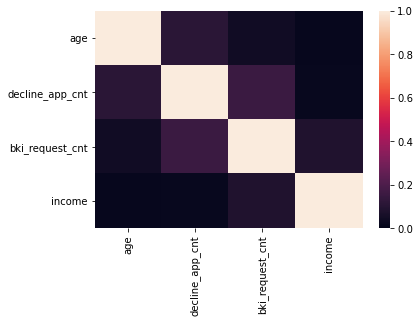

In [24]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

### Значимость непрерывных переменных
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

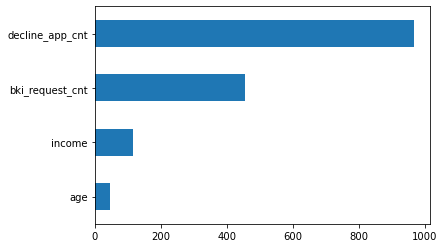

In [27]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

По графику видим, что самый значимый признак из числовых - decline_app_cnt (количество отказанных прошлых заявок)

### Категориальные переменные

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа.  

Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле `sex` значение `sex = female` преобразовать в $0$, а `sex = male` — в $1$. Эту простую операцию приходится делать достаточно часто, поэтому в модуле `sklearn.preprocessing` именно для этой задачи реализован класс `LabelEncoder`.

Метод `fit` этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод `transform` непосредственно преобразует значения в числа. После `fit` у `label_encoder` будет доступно поле `classes_`, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [29]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


Теперь всегда можно обратиться к `classes_ `, если забыли, что закодировали. Применим `LabelEncoder` ко всему набору бинарных переменных.

In [30]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


Почему мы применили метод только к бинарным переменным? Единственным минусом использования кодирования при помощи LabelEncoder() является то, что при использовании этого подхода мы должны быть уверены, что признак не может принимать неизвестных ранее значений. 

→ Что произойдет, если у нас появятся данные с другими категориями? LabelEncoder будет ругаться, что не знает новую категорию. 

Например, если у нас появится новый пол (помимо женского и мужского), признак sex придется обрабатывать по-другому.

Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно.



### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ



Для оценки значимости категориальных и бинарных переменных будем использовать функцию `mutual_info_classif` из библиотеки `sklearn`. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [32]:
data.education.fillna('NAN_EDU',inplace=True)
data.education = label_encoder.fit_transform(data.education)

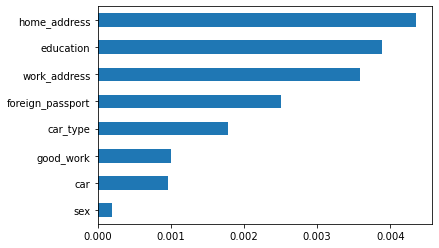

In [33]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols.append(cat_cols)], data['default'],
                                     discrete_features =True), index = bin_cols.append(cat_cols))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [34]:
imp_cat

sex                 0.000192
car                 0.000957
good_work           0.001004
car_type            0.001788
foreign_passport    0.002508
work_address        0.003591
education           0.003881
home_address        0.004356
dtype: float64

In [35]:
data[bin_cols.append(cat_cols)].apply(lambda x: list(x.unique()))

sex                             [1, 0]
car                             [1, 0]
car_type                        [1, 0]
good_work                       [0, 1]
foreign_passport                [0, 1]
education           [4, 1, 5, 3, 0, 2]
home_address                 [1, 2, 3]
work_address                 [2, 3, 1]
dtype: object

### Подготовка данных к машинному обучению


Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

Как вы уже поняли, `LabelEncoder` не совсем подходит для признаков с двумя и большим количеством категорий. Для того, чтобы мы смогли применять линейные модели на таких данных, нам необходим другой метод, который называется `One-Hot Encoding`. Смысл его точно такой же, как у dummy-кодирования.

Предположим, что некоторый признак может принимать пять разных значений. В этом случае One Hot Encoding подразумевает создание пяти новых признаков, все из которых равны нулю, за исключением одного. На позицию, соответствующую численному значению признака, мы помещаем .

Эта техника реализована в `sklearn.preprocessing` в классе `OneHotEncoder`. По умолчанию `OneHotEncoder` преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.

In [36]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

Затем каждое целочисленное значение представляется в виде двоичного вектора. Он в свою очередь представляет собой все нулевые значения, кроме индекса целого числа, который отмечен 1. Когда для выходной переменной используется One Hot Encoding, группа закодированных переменных может предложить более детальный набор предсказаний, чем одна метка.

### Задание 1
Сколько столбцов вы получили после преобразования данных?

In [37]:
X_cat.shape[1]

12

Стандартизируем числовые переменные:

In [39]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(data[num_cols].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [41]:
# Объединяем

X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

Подготовка признаков для модели завершена. 

Разделим данные для обучения следующим образом:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### ЗАДАНИЕ
Обучите модель на стандартных настройках ***логистической регрессии***.

In [43]:
model = LogisticRegression()
model.fit(X_train,y_train)

/home/dell/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Оценка качества модели

В качестве методов оценки прогностической способности модели мы решаем использовать ROC-анализ.

Классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

![1](https://lms.skillfactory.ru/assets/courseware/v1/7b2082e0bb1ef965189eb9a354859a84/asset-v1:Skillfactory+DST-12+11MAR2020+type@asset+block/dst-score-16.png)
В нашем примере положительным исходом будет наличие дефолта у заемщика, отрицательным — отсутствие дефолта.

**→** Доля положительных результатов у «плохих» заемщиков (истинно положительных результатов) — это **чувствительность** модели **(Sensitivity)**, то есть способность модели правильно определять «плохих» заемщиков и минимизировать убытки, связанные с выдачей кредита «плохому» клиенту. 

**→** Доля отрицательных результатов у «хороших» заемщиков (истинно отрицательных результатов) — это **специфичность** модели **(Specificity)**. Здесь речь уже идёт о способности модели правильно определять «хороших» заемщиков и минимизировать убытки, связанные с отказом в выдаче кредита добросовестному клиенту.

![2](https://lms.skillfactory.ru/assets/courseware/v1/74e9564907091d0e3fdc95af5e8f4998/asset-v1:Skillfactory+DST-12+11MAR2020+type@asset+block/dst-score-17.png)

Написав код для построения ROC AUС, вы получили значение метрики 0.671:

/home/dell/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


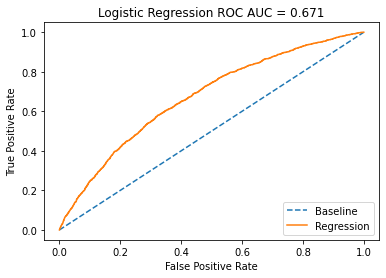

In [44]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Даже без глубокого отбора и конструирования признаков удалось построить модель, чья предсказательная сила заметно отличается от случайного угадывания. Это означает, что шансы построить качественную модель с помощью дополнительной обработки данных достаточно высоки.



### РЕГУЛЯРИЗАЦИЯ

**Гиперпараметры** — это внешние параметры для классификатора, которые не могут быть изучены самим классификатором и чаще всего задаются вручную. Логистическая регрессия, например, не способна сама выучить наилучшее значение для, например, параметра С.  В scikit-learn они передаются в качестве аргументов конструктору класса. Найдя оптимальные параметры, мы можем улучшить предсказательную силу нашей логистической регрессии.

В `scikit-learn` есть два общих подхода к поиску: с помощью `GridSearchCV`  и `RandomizedSearchCV`. 

В этом примере мы рассмотрим поиск гиперпараметров `GridSearchCV` при помощи перебора параметров по сетке с последующей кросс-валидацией. 

In [45]:
%%time
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(-6, 3, 19)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1e-06
CPU times: user 1min 22s, sys: 664 ms, total: 1min 23s
Wall time: 20.9 s


Некоторые модели допускают индивидуальные методы поиска, например, как наша логит-модель. Класс `LogisticRegressionCV` создан специально для логистической регрессии (для неё известны эффективные алгоритмы перебора параметров).

In [46]:
aaa = clf.cv_results_

In [47]:
aaa.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [48]:
clf.cv_results_['params']

[{'C': 1e-06, 'penalty': 'l1'},
 {'C': 1e-06, 'penalty': 'l2'},
 {'C': 3.162277660168379e-06, 'penalty': 'l1'},
 {'C': 3.162277660168379e-06, 'penalty': 'l2'},
 {'C': 1e-05, 'penalty': 'l1'},
 {'C': 1e-05, 'penalty': 'l2'},
 {'C': 3.1622776601683795e-05, 'penalty': 'l1'},
 {'C': 3.1622776601683795e-05, 'penalty': 'l2'},
 {'C': 0.0001, 'penalty': 'l1'},
 {'C': 0.0001, 'penalty': 'l2'},
 {'C': 0.00031622776601683794, 'penalty': 'l1'},
 {'C': 0.00031622776601683794, 'penalty': 'l2'},
 {'C': 0.001, 'penalty': 'l1'},
 {'C': 0.001, 'penalty': 'l2'},
 {'C': 0.0031622776601683794, 'penalty': 'l1'},
 {'C': 0.0031622776601683794, 'penalty': 'l2'},
 {'C': 0.01, 'penalty': 'l1'},
 {'C': 0.01, 'penalty': 'l2'},
 {'C': 0.03162277660168379, 'penalty': 'l1'},
 {'C': 0.03162277660168379, 'penalty': 'l2'},
 {'C': 0.1, 'penalty': 'l1'},
 {'C': 0.1, 'penalty': 'l2'},
 {'C': 0.31622776601683794, 'penalty': 'l1'},
 {'C': 0.31622776601683794, 'penalty': 'l2'},
 {'C': 1.0, 'penalty': 'l1'},
 {'C': 1.0, 'penal

In [49]:
clf.cv_results_['mean_test_score']

array([       nan, 0.87220312,        nan, 0.87220312,        nan,
       0.87220312,        nan, 0.87218618,        nan, 0.87220312,
              nan, 0.87208455,        nan, 0.87184741,        nan,
       0.8717119 ,        nan, 0.8717119 ,        nan, 0.8717119 ,
              nan, 0.87172884,        nan, 0.8717119 ,        nan,
       0.87169496,        nan, 0.8717119 ,        nan, 0.8717119 ,
              nan, 0.8717119 ,        nan, 0.8717119 ,        nan,
       0.8717119 ,        nan, 0.8717119 ])

In [50]:
list(zip(aaa['mean_test_score'],aaa['params']))

[(nan, {'C': 1e-06, 'penalty': 'l1'}),
 (0.87220311982488, {'C': 1e-06, 'penalty': 'l2'}),
 (nan, {'C': 3.162277660168379e-06, 'penalty': 'l1'}),
 (0.87220311982488, {'C': 3.162277660168379e-06, 'penalty': 'l2'}),
 (nan, {'C': 1e-05, 'penalty': 'l1'}),
 (0.87220311982488, {'C': 1e-05, 'penalty': 'l2'}),
 (nan, {'C': 3.1622776601683795e-05, 'penalty': 'l1'}),
 (0.8721861821555033, {'C': 3.1622776601683795e-05, 'penalty': 'l2'}),
 (nan, {'C': 0.0001, 'penalty': 'l1'}),
 (0.87220311982488, {'C': 0.0001, 'penalty': 'l2'}),
 (nan, {'C': 0.00031622776601683794, 'penalty': 'l1'}),
 (0.8720845532701537, {'C': 0.00031622776601683794, 'penalty': 'l2'}),
 (nan, {'C': 0.001, 'penalty': 'l1'}),
 (0.8718474115534329, {'C': 0.001, 'penalty': 'l2'}),
 (nan, {'C': 0.0031622776601683794, 'penalty': 'l1'}),
 (0.8717119015911511, {'C': 0.0031622776601683794, 'penalty': 'l2'}),
 (nan, {'C': 0.01, 'penalty': 'l1'}),
 (0.8717119015911511, {'C': 0.01, 'penalty': 'l2'}),
 (nan, {'C': 0.03162277660168379, 'pena

### ПОДВАЛ

'''
https://lms.skillfactory.ru/assets/courseware/v1/7b2082e0bb1ef965189eb9a354859a84/asset-v1:Skillfactory+DST-12+11MAR2020+type@asset+block/dst-score-16.png

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/450px-Overfitting.svg.png" alt="Overfitting" width="300" align="center">

![Кривые обучения при переобучении](https://developers.google.com/machine-learning/crash-course/images/RegularizationTwoLossFunctions.svg)
''';

In [51]:
np.logspace(-6, 1, 15)

array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01])